In [1]:
## Trim down imports to only neccesary 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from transformers import AutoFeatureExtractor, ViTForImageClassification, ViTModel
import torch
from torchvision.transforms import v2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('default')

from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.utils.data import Subset
from sklearn.preprocessing import StandardScaler

import datasets_1 as datasets

import os
import re
from sklearn.model_selection import GridSearchCV

import itertools
import torch.optim as optim

from datetime import date
from torch.optim.lr_scheduler import StepLR


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still cha

In [7]:
DATA_DIR = "../data/"

lvid_o = pd.read_excel('../data/LVID_bulk_geochem.xlsx')
lvid_o.head()

lvid_o.columns = lvid_o.columns.str.strip()

lvid_o.head()

print(lvid_o.columns)

# Function to clean column names
def clean_column_name(column_name):
    # Remove text within parentheses
    column_name = re.sub(r' \([^)]*\)', '', column_name)
    # Replace spaces with underscores
    column_name = column_name.replace(' ', '_')
    
    # Convert to lower case
    return column_name.lower().strip()

# Apply the function to each column name
lvid_o.columns = [clean_column_name(col) for col in lvid_o.columns]

# Now df has the cleaned column names
print(lvid_o.columns)

lvid_o.describe()

,Sediment_Depth,Age,%TOC,d13C,d15N,%TN,C/N,BSi,year
0,0.0,11.6732,3.6,-25.9,0.7,0.4,8.0,76.672,2020.0000
1,3.0,52.5294,3.1,-25.8,0.7,0.4,8.5,59.449,1979.1438
2,7.0,99.2222,2.9,-25.7,0.6,0.3,9.4,64.895,1932.4510
3,11.0,145.9150,3.1,-25.9,0.3,0.3,9.4,54.073,1885.7582
4,15.0,192.6078,3.1,-25.9,0.7,0.3,9.3,57.037,1839.0654


In [4]:
class ImageData:
    def __init__(self, name, image):
        self.name = name
        self.image = image
        self.start = None
        self.end = None

In [5]:
full_SVID = []
cropped_SVID = []

def sortimg(img):
    return img.name

def load_and_display_images(folder_path, img_store):
    # List all files in the folder
    files = os.listdir(folder_path)

    for file in files:
        # Construct full file path
        file_path = os.path.join(folder_path, file)
        obj_name = file[14:23]
        print(file,obj_name)
        # Check if the file is an image (you can add more extensions if needed)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Open the image
            img = Image.open(file_path)

            new_img = ImageData(name = obj_name, image = img)
            
            # Display the image
            #plt.imshow(img)
            #plt.title(file)
            #plt.show()
            
            img_store.append(new_img)

# Replace 'your_folder_path' with the path to the folder containing your images

load_and_display_images('img_data/SVID',full_SVID)
## reverse = False because 1B-7B seems darkest so would make sense for it to be on the bottom
full_SVID.sort(key=sortimg,reverse=False)

ILLUME-SVID20-1B-7B-1-A.jpg 1B-7B-1-A
ILLUME-SVID20-1B-6B-1-A.jpg 1B-6B-1-A
ILLUME-SVID20-1B-2B-1-A_complete.jpg 1B-2B-1-A
ILLUME-SVID20-1B-3B-1-A_complete.jpg 1B-3B-1-A
ILLUME-SVID20-1B-5B-1-A_complete.jpg 1B-5B-1-A
ILLUME-SVID20-1B-4B-1-A_complete.jpg 1B-4B-1-A
ILLUME-SVID20-1B-1B-1-A_complete.jpg 1B-1B-1-A


(-0.5, 21449.5, 1299.5, -0.5)

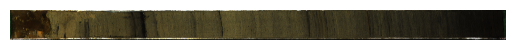

(-0.5, 15149.5, 1299.5, -0.5)

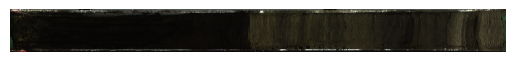

In [6]:
## Cropping Unnecesary parts
# Left, top, right, bottom

## Cropping Unnecesary parts
# Left, top, right, bottom

## This is only guessing, do something better potentially. More fine grain
## 1. 1000 0 31275 1300
    ## 6-157 cm
box = (1000, 0, 31275, 1300)

# Crop the image
cropped_image = full_SVID[0].image.crop(box)
full_SVID[0].start = 1000
full_SVID[0].end = 31275

# Display the cropped image
# plt.imshow(cropped_image)
# plt.axis('off')  # This hides the axis
# plt.show()

cropped_SVID.append(ImageData(full_SVID[0].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 2. 800 0 31290 1300
    ## 5-157 cm
box = (800, 0, 31290, 1300)
full_SVID[1].start = 800
full_SVID[1].end = 31290

# Crop the image
cropped_image = full_SVID[1].image.crop(box)

# Display the cropped image
# plt.imshow(cropped_image)
# plt.axis('off')  # This hides the axis
# plt.show()


cropped_SVID.append(ImageData(full_SVID[1].name,cropped_image))


## This is only guessing, do something better potentially. More fine grain
## 3. 800 0 31100 1300
    ## 5-156 cm
box = (800, 0, 31100, 1300)

# Crop the image
cropped_image = full_SVID[2].image.crop(box)
full_SVID[2].start = 800
full_SVID[2].end = 31100

# # Display the cropped image
# plt.imshow(cropped_image)
# plt.axis('off')  # This hides the axis
# plt.show()

cropped_SVID.append(ImageData(full_SVID[2].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 4. 1200 0 28000 1300
    ## 7-140.5 cm
box = (1200, 0, 28000, 1300)

# Crop the image
cropped_image = full_SVID[3].image.crop(box)
full_SVID[3].start = 1200
full_SVID[3].end = 28000

# Display the cropped image
# plt.imshow(cropped_image)
# plt.axis('off')  # This hides the axis
# plt.show()


cropped_SVID.append(ImageData(full_SVID[3].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 5. 1200 0 31700 1300
    ## 7-159 cm
box = (1200, 0, 31700, 1300)

# Crop the image
cropped_image = full_SVID[4].image.crop(box)
full_SVID[4].start = 1200
full_SVID[4].end = 31700

# Display the cropped image
# plt.imshow(cropped_image)
# plt.axis('off')  # This hides the axis
# plt.show()


cropped_SVID.append(ImageData(full_SVID[4].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 6. 875 0 22325 1300
    ## 5.5-112 cm
box = (875, 0, 22325, 1300)

# Crop the image
cropped_image = full_SVID[5].image.crop(box)
full_SVID[5].start = 875
full_SVID[5].end = 22325

# Display the cropped image
# plt.imshow(cropped_image)
# plt.axis('off')  # This hides the axis
# plt.show()

cropped_SVID.append(ImageData(full_SVID[5].name,cropped_image))

## This is only guessing, do something better potentially. More fine grain
## 7. 1600 0 16750 1300
    ## 9-84 cm
box = (1600, 0, 16750, 1300)

# Crop the image
cropped_image = full_SVID[6].image.crop(box)
full_SVID[6].start = 1600
full_SVID[6].end = 16750

# Display the cropped image
# plt.imshow(cropped_image)
# plt.axis('off')  # This hides the axis
# plt.show()

cropped_SVID.append(ImageData(full_SVID[6].name,cropped_image))




In [9]:
class CustomDataset(Dataset):
    def __init__(self, pixel_values, labels):
        self.pixel_values = pixel_values
        self.labels = labels

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        image = self.pixel_values[idx]
        label = self.labels[idx]
        return image, label


def create_dataset(target,sample_df,images, scaled=True):
    if scaled:
        target_col = target + '_scaled'
    else:
        target_col = target
        



    full_depth = 0
    chunk_size = 997
    chunks = []
    chunk_labels = []

    ## Pixels to cm
        ## To make sure our depths are accurate
    p_to_cm = 5/997


    if scaled:
        # Initialize the StandardScaler
        scaler = StandardScaler()

        # Fit the scaler to the target column and transform it
        sample_df[target_col] = scaler.fit_transform(sample_df[[target]])



    j = 0
    for i,object in enumerate(images):
        full_end = object.end
        start_pixel = object.start
        end_pixel = object.start + chunk_size
        while end_pixel <= full_end:
            box = (start_pixel, 0, end_pixel, 1300)

            ## Adding on labels
            section_data =  sample_df[( sample_df['Sediment_Depth'] >= full_depth) & 
                            ( sample_df['Sediment_Depth'] < (full_depth+5))]

            # Calculate the average target value for the segment
            average_target = section_data[target_col].mean()
            if len(section_data) > 0:
                chunk_labels.append(average_target)
                chunk = object.image.crop(box)

                chunks.append(chunk) 


            ## While loop Increments
            start_pixel += chunk_size
            end_pixel += chunk_size
            j += 1
            if end_pixel > full_end:
                full_depth += (full_end - (end_pixel - chunk_size)) * p_to_cm
            else:
                full_depth += 5
     

     # Convert your lists to numpy arrays
    images_array = np.array(chunks)
    labels_array = np.array(chunk_labels)

    # Assuming NaN is represented as np.nan in labels_array
    # Create boolean masks
    nan_mask = np.isnan(labels_array)
    non_nan_mask = ~nan_mask

    # Filter the arrays
    images_test = images_array[nan_mask]
    images_known = images_array[non_nan_mask]
    labels_test = labels_array[nan_mask]
    labels_known = labels_array[non_nan_mask]


    feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-tiny-patch16-224')
    inputs = feature_extractor(images=images_known, return_tensors="pt")
    
        # Assuming your pixel_values are already a tensor in the shape [num_images, channels, height, width]
    # and labels is a list or a 1-D tensor of label values:
    pixel_values_tensor = inputs['pixel_values'] 
    labels_tensor = torch.tensor(labels_known, dtype=torch.float32)

    # Create the custom dataset
    dataset = CustomDataset(pixel_values_tensor, labels_tensor)

    # Split the dataset into training and validation sets
    train_indices, val_indices = train_test_split(range(len(labels_tensor)), test_size=0.2, random_state=42)

    # Subset for train and validation=
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    # Create a dataloader for both the training and validation sets
        ## 5 seems like a fine batch size
    train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

    return train_loader, val_loader, scaler, inputs

target = "BSi"

train_loader, val_loader, scaler, inputs = create_dataset(target,svid_o, full_SVID)

/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [10]:
## Pretrained model

class CustomViTEmbeddingModel(torch.nn.Module):
    def __init__(self, original_model):
        super(CustomViTEmbeddingModel, self).__init__()
        
        # Extract the necessary layers from the original model
        self.embeddings = original_model.vit.embeddings  #.patch_embeddings
        self.encoder_layer_0 = original_model.vit.encoder.layer[0]
        self.encoder_layer_1 = original_model.vit.encoder.layer[1]
        
        # Assume a square grid of patches to reshape the sequence of patches back into a 2D grid
            ## image: 224x224 ; patch size: 16x16 --> 14x14 
        self.num_patches_side = 14

    def forward(self, x):
        # Apply the embeddings layer
        x = self.embeddings(x)
        
        # Pass the result through the first and second encoder layers
        x = self.encoder_layer_0(x)[0]  # [0] to get the hidden states
        x = self.encoder_layer_1(x)[0]  # [0] to get the hidden states
        
        # x is now the sequence of embeddings for the patches
            # The output x will be a sequence of embeddings, one for each patch of the input images.
            # If you're looking for a single vector representation per image, typically the class token embedding (the first token) is used. 
            # If the model doesn't use a class token, you might need to apply a different pooling strategy over the patch embeddings.
        
        ## Updating to reshape
        
        # Before reshaping, x is in shape [batch_size, num_patches+1, embedding_dim]
        # We discard the first token which is used for classification in the original ViT model
        x = x[:, 1:, :]  # Now in shape [batch_size, num_patches, embedding_dim]
        
        # Reshape to [batch_size, num_patches_side, num_patches_side, embedding_dim]
        x = x.reshape(-1, self.num_patches_side, self.num_patches_side, x.size(-1))

        # Permute to get [batch_size, embedding_dim, num_patches_side, num_patches_side]
        # This is a pseudo-spatial 2D grid, where embedding_dim becomes the channel dimension
        x = x.permute(0, 3, 1, 2)
        
        return x
    
def calculate_rmse_and_r2(loader, model, scaler):
    model.eval()
    targets, predictions = [], []
    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            embeddings = custom_model(images)  # Get embeddings from the ViT
            preds = model(embeddings)  # Pass embeddings to the CNN
            predictions.extend(preds.view(-1).tolist())
            targets.extend(labels.tolist())

    # Scale the targets using the provided scaler
    targets_scaled = scaler.transform(np.array(targets).reshape(-1, 1)).flatten()

    # Convert to tensors
    predictions = torch.tensor(predictions)
    targets_scaled = torch.tensor(targets_scaled)

    # Calculate RMSE on scaled targets
    rmse_value = torch.sqrt(nn.functional.mse_loss(predictions, targets_scaled))

    # Calculate R^2 on scaled targets
    r2_value = r2_score(targets_scaled, predictions)

    return rmse_value.item(), r2_value


# Load the pre-trained ViT model
pretrained_vit = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')

## Freeze params
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Create model w first three layers and create embedding
custom_model = CustomViTEmbeddingModel(pretrained_vit)
embeddings = custom_model(inputs['pixel_values']) 

print(embeddings[0].shape)

torch.Size([192, 14, 14])


In [14]:
## Preventing model arch from printing everytime
InteractiveShell.ast_node_interactivity = "last_expr"
warnings.filterwarnings('ignore')

In [31]:
## Grid Search
    ## Second grid search

class GridRegressionCNN(nn.Module):
    def __init__(self, embedding_dim, layer_sizes, use_dropout=True, use_batch_norm=True, act_func=nn.ReLU()):
        super(GridRegressionCNN, self).__init__()
        
        layers = []
        in_channels = embedding_dim

        for size in layer_sizes:
            layers.append(nn.Conv2d(in_channels, size, kernel_size=3, padding=1))
            
            if use_batch_norm:
                layers.append(nn.BatchNorm2d(size))
            
            layers.append(act_func)

            if use_dropout:
                ## Changed to 0.1 on 12/19
                layers.append(nn.Dropout(p=0.1))

            in_channels = size

        layers.append(nn.AdaptiveAvgPool2d((1, 1)))

        ## convert list into sequential
        self.layers = nn.Sequential(*layers)

        self.fc = nn.Linear(in_features=layer_sizes[-1], out_features=1)

    def forward(self, x):
        x = self.layers(x)

        ## flattening tensor for fully connected
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc(x)
        return x
    


In [41]:
# Define the hyperparameter grid

num_epochs = 50

param_grid = {
    'learning_rate': [0.000001, 0.00005, 0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01],
    'layer_sizes': [[256,64]],
    'use_dropout': [True],
    'use_batch_norm': [True],
    'activations': [nn.Sigmoid()],
    'epochs': [50,100,200]
}

# Create a list of all possible combinations of hyperparameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Function to train and evaluate the model
def train_evaluate_model(params,train_loader,val_loader,scaler, df, scaled = True):
    model = GridRegressionCNN(embedding_dim=192, layer_sizes=params['layer_sizes'], use_dropout=params['use_dropout'], use_batch_norm=params['use_batch_norm'],act_func = params['activations'])
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    loss_function = nn.MSELoss()

    # Reset metrics for each training session
    train_losses = []
    train_rmses = []
    val_rmses = []
    
    for epoch in range(params['epochs']):
        model.train()
        train_loss = 0
        #print(f'epoch {epoch} of {epochs}')
        for batch in train_loader:
            optimizer.zero_grad()
            images, labels = batch
            embeddings = custom_model(images)  # Get embeddings from the ViT
            predictions = model(embeddings)  # Pass embeddings to the CNN
            loss = loss_function(predictions.squeeze(), labels) 
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Append average loss and RMSE for this epoch
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_rmse, _ = calculate_rmse_and_r2(train_loader, model, scaler)
        val_rmse, _ = calculate_rmse_and_r2(val_loader, model, scaler)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print(f'PERFORMANCE: \n params: {params}, \n val_rmse: {val_rmses[-1]} \n')
    range_target = np.max(df[target]) - np.min(df[target])
    if scaled:
        normal_rmse = scaler.inverse_transform([[val_rmses[-1]]])[0, 0]
        rmse_perc = (normal_rmse / range_target) * 100
    else:
        rmse_perc = (val_rmses[-1] / range_target) * 100

    return {'train_rmse': train_rmses[-1], 'val_rmse': val_rmses[-1], 'rmse_perc': rmse_perc}





In [ ]:
# Iterate over each combination of hyperparameters
results = []
for params in all_params:
    performance = train_evaluate_model(params,num_epochs, train_loader,val_loader,scaler, lvid_o)
    results.append({'params': params, 'performance': performance})

# Convert results to a DataFrame for easier handling
results_df = pd.DataFrame([{
    'learning_rate': r['params']['learning_rate'],
    'layer_sizes': r['params']['layer_sizes'],
    'use_dropout': r['params']['use_dropout'],
    'use_batch_norm': r['params']['use_batch_norm'],
    'train_rmse': r['performance']['train_rmse'],
    'val_rmse': r['performance']['val_rmse'],
    'RMSE %': r['performance']['rmse_perc']
} for r in results])

# Save the results to a CSV file
title = "grid_results/" + "SVID/" + target + "/" + today.strftime("%d%m%Y") + '_grid_search_results.csv'
results_df.to_csv(title, index=False)

In [44]:
def manual_grid_search(lake,target,param_grid, train_loader, val_loader,scaler, df):
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    results = []
    for params in all_params:
        epochs = params['epochs']
        print(f'epochs {epochs}')
        performance = train_evaluate_model(params, train_loader, val_loader,scaler, df)
        results.append({'params': params, 'performance': performance})

    # Convert results to a DataFrame for easier handling
    results_df = pd.DataFrame([{
        'epochs': r['params']['epochs'],
        'learning_rate': r['params']['learning_rate'],
        'layer_sizes': r['params']['layer_sizes'],
        'use_dropout': r['params']['use_dropout'],
        'use_batch_norm': r['params']['use_batch_norm'],
        'activation': r['params']['activations'],
        'train_rmse': r['performance']['train_rmse'],
        'val_rmse': r['performance']['val_rmse'],
        'RMSE %': r['performance']['rmse_perc']
    } for r in results])

    # Save the results to a CSV file
    target = target.replace("/", "-")
    title = "grid_results/" + lake + "/" + target + "_" + date.today().strftime("%d%m%Y_%H%M%S") + '_grid_search_results.csv'
    results_df.to_csv(title, index=False)

In [45]:
## Warnings off
## Preventing model arch from printing everytime
InteractiveShell.ast_node_interactivity = "last_expr"
warnings.filterwarnings('ignore')

#['sample_id', 'section_depth', 'cum_depth', 'age', 'δ13cvpdb', 'total_c',
        #'%toc', 'δ15nair', 'total_n', '%n', 'c/n',
       #'sample_weight_from_sample_list', 'sample_mass'] MBT
        
        ## lvid_o or df
## Create Training set for each in for loop

## have a way to turn off scaling?
## TOC not included for now, did it manually before

# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'layer_sizes': [[256, 128, 64], [128, 64, 32], [128, 128, 128],[128, 64], [256,64],[512,128,64]],
#     'use_dropout': [True, False],
#     'use_batch_norm': [True, False],
#     'activations': [nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid()]
# }

param_grid = {
    'learning_rate': [0.00000001, 0.00000005, 0.0000001, 0.000005, 0.000001, 0.00005, 0.00001, 0.0005, 0.0001, 0.005, 0.001],
    'layer_sizes': [[256,64]],
    'use_dropout': [True],
    'use_batch_norm': [True],
    'activations': [nn.Sigmoid()],
    'epochs': [50,100,200]
}

targets = ['%TOC']
lake = 'SVID'
for target in targets:
    print(f'BEGIN {target}\n')
    data_df = svid_o
    if target == "MBT":
        data_df = df
        train_loader,val_loader,scaler, _ = create_dataset(target,data_df, full_SVID)
    else:
        train_loader,val_loader,scaler, _ = create_dataset(target, data_df, full_SVID)
    
        
    ## Do grid search in function
    manual_grid_search(lake, target, param_grid, train_loader, val_loader,scaler, data_df)
    print(f'FINISHED {target}\n')


BEGIN %TOC

epochs 50
PERFORMANCE: 
 params: {'learning_rate': 1e-08, 'layer_sizes': [256, 64], 'use_dropout': True, 'use_batch_norm': True, 'activations': Sigmoid(), 'epochs': 50}, 
 val_rmse: 1.7524813465574591 

epochs 100
PERFORMANCE: 
 params: {'learning_rate': 1e-08, 'layer_sizes': [256, 64], 'use_dropout': True, 'use_batch_norm': True, 'activations': Sigmoid(), 'epochs': 100}, 
 val_rmse: 2.4989998470491326 

epochs 200
PERFORMANCE: 
 params: {'learning_rate': 1e-08, 'layer_sizes': [256, 64], 'use_dropout': True, 'use_batch_norm': True, 'activations': Sigmoid(), 'epochs': 200}, 
 val_rmse: 2.0128678261348782 

epochs 50
PERFORMANCE: 
 params: {'learning_rate': 5e-08, 'layer_sizes': [256, 64], 'use_dropout': True, 'use_batch_norm': True, 'activations': Sigmoid(), 'epochs': 50}, 
 val_rmse: 1.738050363461627 

epochs 100
PERFORMANCE: 
 params: {'learning_rate': 5e-08, 'layer_sizes': [256, 64], 'use_dropout': True, 'use_batch_norm': True, 'activations': Sigmoid(), 'epochs': 100}, 
